# IA – Projeto 02
## Classification – Previsão de Pódio F1

**Unidade Curricular:** Inteligência Artificial  
**Ano Letivo:** 2025/2026  

### Discentes

- Carlos Sousa (24880)  
- Pedro Gonçalves (26018)  
- Carlos Moreda (26875)  

---

## 1. Introdução e Objetivos

Neste projeto vamos analisar dados históricos de Fórmula 1, recorrendo ao dataset **“Formula 1 Race Data (1950–2017)”**, disponível no Kaggle. 

Dataset original: **[Formula 1 Race Data (Kaggle)](https://www.kaggle.com/datasets/cjgdev/formula-1-race-data-19502017)**

O ficheiro principal com que iremos trabalhar `results.csv` contém, linha a linha, do resultado de um piloto numa corrida específica entre as temporadas de 1950 a 2017.

O objetivo nesta fase é utilizar dados de resultados e formulá-los como um problema de classificação supervisionada onde iremos treinar modelos de Machine Learning que, usando apenas informação conhecida antes da corrida, nos estimem se um determinado piloto vai ou não terminar no pódio (Top 3).

Em resumo, a ideia é:

- Usar informação pré-corrida (posição de partida, piloto, equipa, corrida, contexto da época, circuito, nacionalidade, etc.) para o modelo tentar prever se o piloto vai terminar no pódio ou não;
- No final, comparar a previsão do modelo com o valor real da coluna `Podium`, criada a partir de `positionOrder`, e avaliar se o modelo acertou

Do ponto de vista de análise desportiva, isto nos permite:

- Identificar características associadas a pilotos que conseguem chegar ao **pódio**;
- Perceber o impacto no **grid**, da **equipa** e do **circuito** nas probabilidades de pódio;
- Apoiar análises históricas sobre desempenho de pilotos e equipas em diferentes corridas.

Como o número de pódios é muito menor do que o número de resultados normais (fora do top 3), o problema é **desbalanceado**.  
Por isso, vamos dar importância a métricas como:

- **Balanced Accuracy**  
- **Precision, Recall e F1-score**  
- **Matriz de confusão**

No resto do notebook vamos:

1. Fazer uma análise exploratória rápida ao dataset (EDA);  
2. Definir as features que vão ser usadas como dados de entrada do modelo;  
3. Separar o dataset em treino e teste;  
4. Treinar e comparar dois algoritmos de classificação: **SVM (RBF)** e **Decision Tree**;  
5. Avaliar os modelos com métricas como Accuracy, Balanced Accuracy, matriz de confusão e *classification report*;  
6. Otimizar a Decision tree


#### Imports e Configuração Inicial

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    classification_report
)

%matplotlib inline
sns.set(style="whitegrid")

#### Carregamento dos datasets de F1

In [2]:
# Carregar ficheiro de resultados
results = pd.read_csv("results.csv")

# Carregar ficheiros de contexto
races = pd.read_csv("races.csv")                                   # informação da corrida (ano, circuito, data,etc)
drivers = pd.read_csv("drivers.csv", encoding="latin1")            # info dos pilotos
constructors = pd.read_csv("constructors.csv", encoding="latin1")  # info das equipas
circuits = pd.read_csv("circuits.csv", encoding="latin1")          # info dos circuitos

### Junção dos dados dos datasets

In [3]:
# Adicionar ano, ronda e circuito
df = results.merge(
    races[["raceId", "year", "round", "circuitId"]],
    on="raceId",
    how="left"
)

# Adicionar país do circuito
df = df.merge(
    circuits[["circuitId", "country"]],
    on="circuitId",
    how="left"
)

# Adicionar nacionalidade do piloto
df = df.merge(
    drivers[["driverId", "nationality"]],
    on="driverId",
    how="left",
    suffixes=("", "_driver")
)

# Adicionar nome e nacionalidade da equipa
df = df.merge(
    constructors[["constructorId", "name", "nationality"]],
    on="constructorId",
    how="left",
    suffixes=("", "_constructor")
)

# Ver as primeiras linhas do dataset final
df.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,fastestLapTime,fastestLapSpeed,statusId,year,round,circuitId,country,nationality,name,nationality_constructor
0,1,18,1,1,22.0,1,1.0,1,1,10.0,...,01:27.5,218.3,1,2008,1,1,Australia,British,McLaren,British
1,2,18,2,2,3.0,5,2.0,2,2,8.0,...,01:27.7,217.586,1,2008,1,1,Australia,German,BMW Sauber,German
2,3,18,3,3,7.0,7,3.0,3,3,6.0,...,01:28.1,216.719,1,2008,1,1,Australia,German,Williams,British
3,4,18,4,4,5.0,11,4.0,4,4,5.0,...,01:28.6,215.464,1,2008,1,1,Australia,Spanish,Renault,French
4,5,18,5,1,23.0,3,5.0,5,5,4.0,...,01:27.4,218.385,1,2008,1,1,Australia,Finnish,McLaren,British


#### Criação da variavel `Podium`

In [4]:
# Remover linhas sem posição final 
df = df.dropna(subset=["positionOrder"])

# Garantir que a coluna positionOrder é inteira
df["positionOrder"] = df["positionOrder"].astype(int)

# Criar a variável alvo: 1 se terminou no pódio , 0 caso contrário
df["Podium"] = (df["positionOrder"] <= 3).astype(int)

# Ver primeiras linhas
df.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,fastestLapSpeed,statusId,year,round,circuitId,country,nationality,name,nationality_constructor,Podium
0,1,18,1,1,22.0,1,1.0,1,1,10.0,...,218.3,1,2008,1,1,Australia,British,McLaren,British,1
1,2,18,2,2,3.0,5,2.0,2,2,8.0,...,217.586,1,2008,1,1,Australia,German,BMW Sauber,German,1
2,3,18,3,3,7.0,7,3.0,3,3,6.0,...,216.719,1,2008,1,1,Australia,German,Williams,British,1
3,4,18,4,4,5.0,11,4.0,4,4,5.0,...,215.464,1,2008,1,1,Australia,Spanish,Renault,French,0
4,5,18,5,1,23.0,3,5.0,5,5,4.0,...,218.385,1,2008,1,1,Australia,Finnish,McLaren,British,0


#### Informação Geral e Estatísticas Descritivas

In [5]:
# Informação geral sobre o dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23777 entries, 0 to 23776
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   resultId                 23777 non-null  int64  
 1   raceId                   23777 non-null  int64  
 2   driverId                 23777 non-null  int64  
 3   constructorId            23777 non-null  int64  
 4   number                   23771 non-null  float64
 5   grid                     23777 non-null  int64  
 6   position                 13227 non-null  float64
 7   positionText             23777 non-null  object 
 8   positionOrder            23777 non-null  int64  
 9   points                   23777 non-null  float64
 10  laps                     23777 non-null  int64  
 11  time                     6004 non-null   object 
 12  milliseconds             6003 non-null   float64
 13  fastestLap               5383 non-null   float64
 14  rank                  

In [6]:
# Estatísticas descritivas das colunas numéricas
df.describe()

,resultId,raceId,driverId,constructorId,number,grid,position,positionOrder,points,laps,milliseconds,fastestLap,rank,statusId,year,round,circuitId,Podium
count,23777.000000,23777.000000,23777.000000,23777.000000,23771.000000,23777.000000,13227.000000,23777.000000,23777.000000,23777.000000,6.003000e+03,5383.000000,5531.000000,23777.000000,23777.000000,23777.00000,23777.000000,23777.000000
mean,11889.481053,487.203937,226.515961,46.281785,16.965462,11.270303,7.782264,13.081591,1.601403,45.270598,6.303313e+06,41.061676,10.598807,18.242293,1987.675064,8.16987,21.735375,0.124069
std,6864.691322,269.904857,231.386102,56.174091,13.644798,7.346436,4.745105,7.824711,3.665154,30.525404,1.721748e+06,17.156435,6.272457,26.380824,17.972231,4.78899,15.806595,0.329668
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.474899e+06,2.000000,0.000000,1.000000,1950.000000,1.00000,1.000000,0.000000
25%,5945.000000,273.000000,55.000000,6.000000,7.000000,5.000000,4.000000,7.000000,0.000000,20.000000,5.442948e+06,29.000000,5.000000,1.000000,1975.000000,4.00000,9.000000,0.000000
50%,11889.000000,478.000000,154.000000,25.000000,15.000000,11.000000,7.000000,13.000000,0.000000,52.000000,5.859428e+06,44.000000,11.000000,11.000000,1989.000000,8.00000,18.000000,0.000000
75%,17833.000000,718.000000,314.000000,57.000000,23.000000,17.000000,11.000000,19.000000,1.000000,66.000000,6.495440e+06,53.000000,16.000000,16.000000,2003.000000,12.00000,32.000000,0.000000
max,23781.000000,988.000000,843.000000,210.000000,208.000000,34.000000,33.000000,39.000000,50.000000,200.000000,1.509054e+07,78.000000,24.000000,136.000000,2017.000000,21.00000,73.000000,1.000000


## 2. Análise Exploratória Rápida (EDA)

Antes de avançar para a modelação, vamos fazer uma análise exploratória inicial para perceber melhor os dados:

- Verificar se existem valores em falta em alguma coluna;
- Analisar a distribuição da variável `Podium`;
- Observar a distribuição de algumas métricas (grid, pontos, voltas, etc.) através de histogramas.


#### Valores em Falta por Coluna

In [7]:
# Valores em falta por coluna
df.isna().sum()

resultId                       0
raceId                         0
driverId                       0
constructorId                  0
number                         6
grid                           0
position                   10550
positionText                   0
positionOrder                  0
points                         0
laps                           0
time                       17773
milliseconds               17774
fastestLap                 18394
rank                       18246
fastestLapTime             18394
fastestLapSpeed            18394
statusId                       0
year                           0
round                          0
circuitId                      0
country                        0
nationality                    0
name                           0
nationality_constructor        0
Podium                         0
dtype: int64

#### Distribuição da Variável Podium

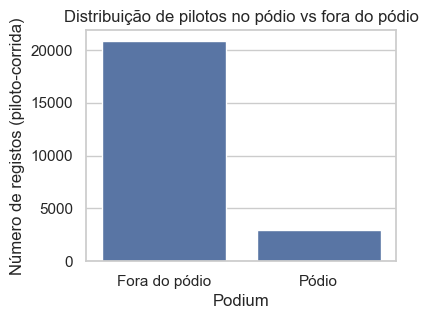

In [8]:
# Gráfico da distribuição de Podium
plt.figure(figsize=(4, 3))
sns.countplot(data=df, x="Podium")
plt.xticks([0, 1], ["Fora do pódio", "Pódio"])
plt.title("Distribuição de pilotos no pódio vs fora do pódio")
plt.xlabel("Podium")
plt.ylabel("Número de registos (piloto-corrida)")
plt.show()

In [9]:
numeric_cols = df.select_dtypes(include=['number']).columns
numeric_cols

Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionOrder', 'points', 'laps', 'milliseconds',
       'fastestLap', 'rank', 'statusId', 'year', 'round', 'circuitId',
       'Podium'],
      dtype='object')

#### Histogramas das Variáveis Numéricas

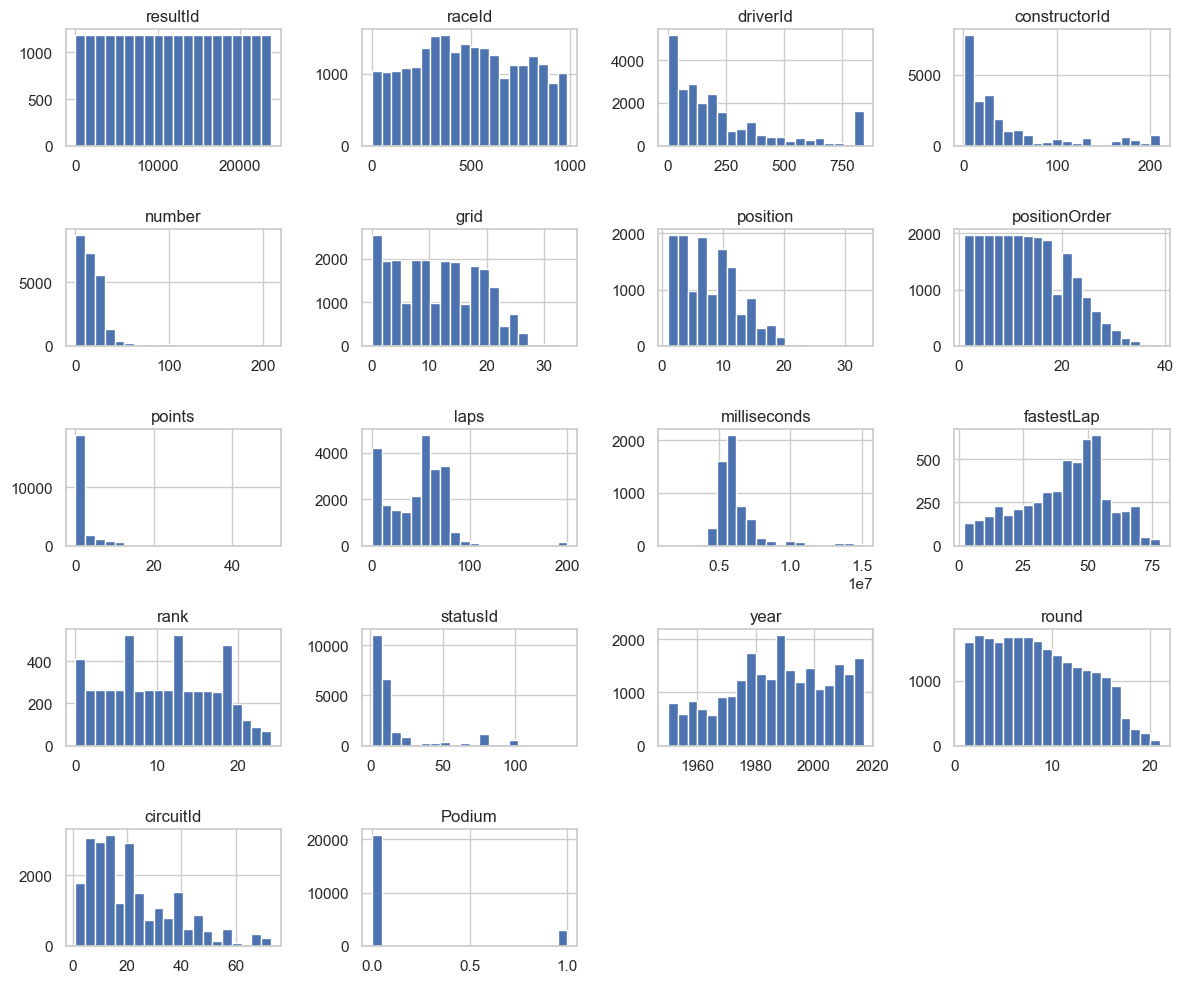

In [10]:
df[numeric_cols].hist(figsize=(12, 10), bins=20)
plt.tight_layout()
plt.show()

### 2.1. Observações EDA

- O dataset final resulta da junção de vários ficheiros:
  - `results.csv` (resultado de cada piloto em cada corrida),
  - `races.csv` (informação da corrida como ano, ronda, circuito),
  - `drivers.csv` (informação do piloto como nacionalidade),
  - `constructors.csv` (informação da equipa),
  - `circuits.csv` (informação do circuito como país).

- A variável alvo `Podium` está desbalanceada:
  - A grande maioria dos pilotos não termina no pódio;
  - Só uma pequena percentagem de registos corresponde a pódios.

- Existem várias colunas que descrevem ou influenciam o resultado final da corrida:
  - `position`, `positionText`, `positionOrder`, `points`, `laps`, `time`, `milliseconds`, `fastestLap`, `rank`, `fastestLapTime`, `fastestLapSpeed`, `statusId`.

Como queremos prever o pódio antes da corrida acontecer, não podemos usar estas colunas como features, porque isso criaria data leakage em vez disso, vamos usar apenas informação que é conhecida antes da corrida e contexto geral:

- qual corrida e época (`raceId`, `year`, `round`, `circuitId`, `country`),
- que piloto (`driverId`, `nationality`),
- que equipa (`constructorId`, `nationality_constructor`),
- posição na grelha (`grid`).

A variável alvo será:

- `Podium` 


## 3. Preparação dos Dados

Após a análise exploratória, é necessário transformar o dataset numa forma adequada para treinar os modelos de classificação. Nesta secção vamos:

1. Selecionar as features que serão usadas como dados de entrada (X) e definir a variável alvo (y);
2. Separar o dataset em conjuntos de treino e teste, garantindo que a proporção de pódios se mantém;
3. Definir o pré-processamento adequado para cada tipo de variável:

O objetivo desta fase é garantir que todas as variáveis estão na escala e formato certos para os algoritmos (SVM e Decision Tree), evitando data leakage e mantendo uma separação clara entre treino e teste.


#### Definição de X e Y + Tipos de Variáveis

In [11]:
# Features a utilizar
feature_cols = [
    "grid",                                     # posição de partida 
    "year", "round",                            # contexto temporal da época
    "circuitId", "country",                     # info do circuito
    "driverId", "nationality",                  # piloto
    "constructorId", "nationality_constructor"  # equipa
]

# Remover linhas que não tenham estas features ou a variável alvo
df_features = df.dropna(subset=feature_cols + ["Podium"])

X = df_features[feature_cols].copy()
y = df_features["Podium"]

print("Formato de X:", X.shape)
print("Formato de y:", y.shape)

X.head()

Formato de X: (23777, 9)
Formato de y: (23777,)


,grid,year,round,circuitId,country,driverId,nationality,constructorId,nationality_constructor
0,1,2008,1,1,Australia,1,British,1,British
1,5,2008,1,1,Australia,2,German,2,German
2,7,2008,1,1,Australia,3,German,3,British
3,11,2008,1,1,Australia,4,Spanish,4,French
4,3,2008,1,1,Australia,5,Finnish,1,British


In [12]:
# Definir features numéricas e categóricas
numeric_features = ["grid", "year", "round"]

categorical_features = [
    "circuitId",
    "country",
    "driverId",
    "nationality",
    "constructorId",
    "nationality_constructor"
]

print("Features numéricas:", numeric_features)
print("Features categóricas:", categorical_features)

Features numéricas: ['grid', 'year', 'round']
Features categóricas: ['circuitId', 'country', 'driverId', 'nationality', 'constructorId', 'nationality_constructor']


## 4. Preparação Teste/Treino

Passos principais de preparação:

1. **Train-test split**
   - Dividir os dados em:
     - Treino: 80%
     - Teste: 20%

2. **Escalonamento das variáveis numéricas**
   - Usar `StandardScaler` para colocar as variáveis numéricas numa escala comparável.

3. **Codificação de variáveis categóricas**
   - As colunas categóricas (circuitId, country, driverId, nationality, constructorId, nationality_constructor) serão codificadas com OneHotEncoder, criando colunas binárias para cada categoria.

4. **Uso de `ColumnTransformer`**
   - Definimos um `ColumnTransformer` que aplica:
     - `StandardScaler` às colunas numéricas;
     - `OneHotEncoder` às colunas categóricas.

#### Train/Test Split e Preprocessor

In [13]:
# Train/test split com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Treino:", X_train.shape, " | Teste:", X_test.shape)
print("Proporção de pódios no treino:", y_train.mean())
print("Proporção de pódios no teste:", y_test.mean())

Treino: (19021, 9)  | Teste: (4756, 9)
Proporção de pódios no treino: 0.12407339256611113
Proporção de pódios no teste: 0.124053826745164


#### Definição do preprocessor

In [14]:
# Definição do preprocessor
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

preprocessor

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

## 5. Algoritmos de Classificação Selecionados

Neste notebook comparamos dois algoritmos de classificação:

1. **Support Vector Machine (SVM)** 
2. **Decision Tree (Árvore de Decisão)**  

Dado o desbalanceamento da variável `Podium`, iremos:

- Utilizar a métrica **Balanced Accuracy** para comparar os modelos;  
- Usar `class_weight='balanced'` na **Decision Tree** para dar mais peso à classe minoritária (pódios).


#### Definição dos modelos + treino/avaliação (SVM + Decision Tree)

In [15]:
# Definir modelos SVM e Decision Tree
models = {
    "SVM (RBF)": SVC(
        kernel="rbf",
        C=10,
        gamma="scale",
        random_state=42
    ),
    "Decision Tree": DecisionTreeClassifier(
        random_state=42,
        class_weight="balanced"
    )
}

results = [] 
cms = [] 

#### Treino e Avaliação dos 2 Modelos

In [16]:
# Treinar e avaliar cada modelo
for name, model in models.items():

    clf = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])
    
    # Treino
    clf.fit(X_train, y_train)
    
    # Previsão no conjunto de teste
    y_pred = clf.predict(X_test)
    
    # Métricas principais
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    
    print(f"Accuracy (test):          {acc:.4f}")
    print(f"Balanced accuracy (test): {bal_acc:.4f}")
    
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))
    
    # Guardar resultados para comparação
    results.append({
        "Modelo": name,
        "Accuracy": acc,
        "Balanced_Accuracy": bal_acc
    })
    
    # Guardar matriz de confusão para usar nos gráficos
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    cms.append((name, cm))

Accuracy (test):          0.8747
Balanced accuracy (test): 0.6731

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      4166
           1       0.49      0.41      0.45       590

    accuracy                           0.87      4756
   macro avg       0.71      0.67      0.69      4756
weighted avg       0.87      0.87      0.87      4756

Accuracy (test):          0.8528
Balanced accuracy (test): 0.6701

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      4166
           1       0.41      0.43      0.42       590

    accuracy                           0.85      4756
   macro avg       0.66      0.67      0.67      4756
weighted avg       0.86      0.85      0.85      4756



#### Gráficos das matrizes de confusão (para SVM e Decision Tree)

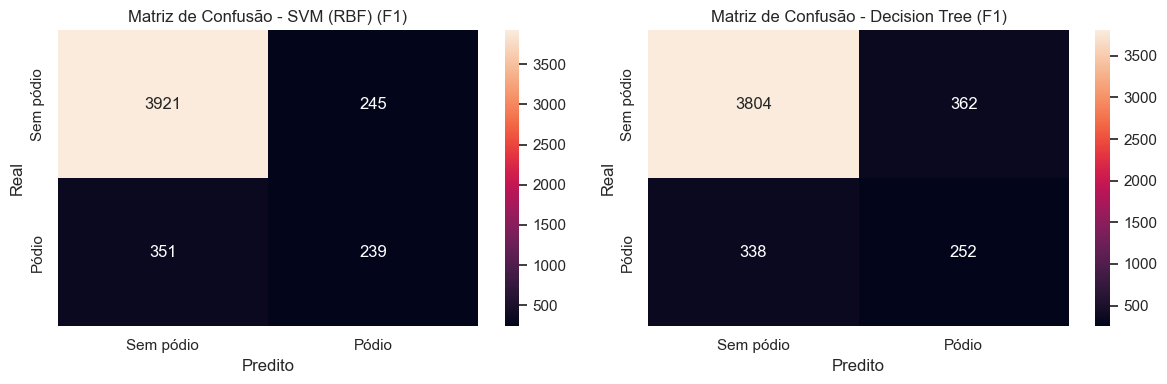

In [17]:
# Gráficos das matrizes de confusão para SVM e Decision Tree 
n_models = len(cms)

fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 4))

if n_models == 1:
    axes = [axes]

for ax, (name, cm) in zip(axes, cms):
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=["Sem pódio", "Pódio"],
        yticklabels=["Sem pódio", "Pódio"],
        ax=ax
    )
    ax.set_xlabel("Predito")
    ax.set_ylabel("Real")
    ax.set_title(f"Matriz de Confusão - {name} (F1)")
    
plt.tight_layout()
plt.show()

#### Tabela e Gráfico de Comparação

In [18]:
# Tabela comparativa dos modelos
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Balanced_Accuracy", ascending=False).reset_index(drop=True)
results_df

,Modelo,Accuracy,Balanced_Accuracy
0,SVM (RBF),0.874685,0.673138
1,Decision Tree,0.852817,0.670112


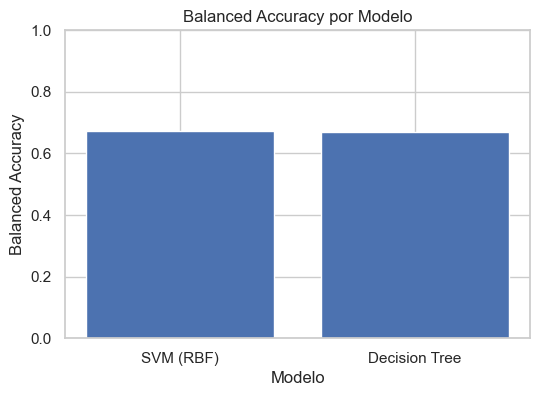

In [19]:
# Gráfico da Balanced Accuracy por modelo
plt.figure(figsize=(6, 4))
plt.bar(results_df["Modelo"], results_df["Balanced_Accuracy"])
plt.title("Balanced Accuracy por Modelo")
plt.xlabel("Modelo")
plt.ylabel("Balanced Accuracy")
plt.ylim(0, 1)
plt.show()

## 6. Otimização de Hiperparâmetros – Decision Tree

Nesta parte vamos otimizar o modelo **Decision Tree** usando `GridSearchCV`.

A árvore de decisão tem vários hiperparâmetros que controlam a complexidade do modelo, nomeadamente:

- `max_depth` – profundidade máxima da árvore;
- `min_samples_split` – número mínimo de amostras necessárias para dividir um nó;
- `min_samples_leaf` – número mínimo de amostras em cada folha.

Valores muito altos podem nos levar overfitting, enquanto valores demasiado baixos podem causar underfitting.
Para encontrar um meio termo adequado, vamos testar algumas combinações destes parâmetros, usando:

- `scoring="balanced_accuracy"` – métrica adequada ao desbalanceamento da variável `Podium`;
- `cv=3` – validação cruzada em 3 partes;
- `n_jobs=-1` – utilização de todos os núcleos disponíveis.


#### GridSearchCV para a Decision Tree

In [20]:
# Modelo base de Decision Tree que será otimizado
tree_base = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced"
)

# Pipeline - preprocessor + Decision Tree
pipe_tree = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", tree_base)
])

# Grelha de hiperparâmetros para Decision Tree
param_grid_tree = {
    "model__max_depth": [5, 10, 15], # testar diferentes profundidades
    "model__min_samples_split": [2, 20], # testar diferentes mínimos de amostras para dividir
    "model__min_samples_leaf": [1, 5] # testar diferentes mínimos de amostras por folha
}

grid_search_tree = GridSearchCV(
    estimator=pipe_tree,
    param_grid=param_grid_tree,
    scoring="balanced_accuracy",
    cv=3, 
    n_jobs=-1,
    verbose=1
)

grid_search_tree.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__max_depth': [5, 10, ...], 'model__min_samples_leaf': [1, 5], 'model__min_samples_split': [2, 20]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'balanced_accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter c

In [21]:
print("\nMelhor balanced accuracy:")
print(grid_search_tree.best_score_)


Melhor balanced accuracy:
0.8115033655669966


#### Avaliação da Decision Tree Otimizada

In [22]:
# Melhor modelo Decision Tree encontrado
best_tree = grid_search_tree.best_estimator_

# Previsões no conjunto de teste
y_pred_tree_opt = best_tree.predict(X_test)

acc_tree_opt = accuracy_score(y_test, y_pred_tree_opt)
bal_acc_tree_opt = balanced_accuracy_score(y_test, y_pred_tree_opt)

print(f"Accuracy (test) - Decision Tree otimizada:          {acc_tree_opt:.4f}")
print(f"Balanced accuracy (test) - Decision Tree otimizada: {bal_acc_tree_opt:.4f}")

# Matriz de confusão 
cm_tree_opt = confusion_matrix(y_test, y_pred_tree_opt, labels=[0, 1])

print("\nClassification report (Decision Tree otimizada):")
print(classification_report(y_test, y_pred_tree_opt))


Accuracy (test) - Decision Tree otimizada:          0.7763
Balanced accuracy (test) - Decision Tree otimizada: 0.8177

Classification report (Decision Tree otimizada):
              precision    recall  f1-score   support

           0       0.98      0.76      0.86      4166
           1       0.34      0.87      0.49       590

    accuracy                           0.78      4756
   macro avg       0.66      0.82      0.67      4756
weighted avg       0.90      0.78      0.81      4756



#### Visualização da Decision Tree otimizada

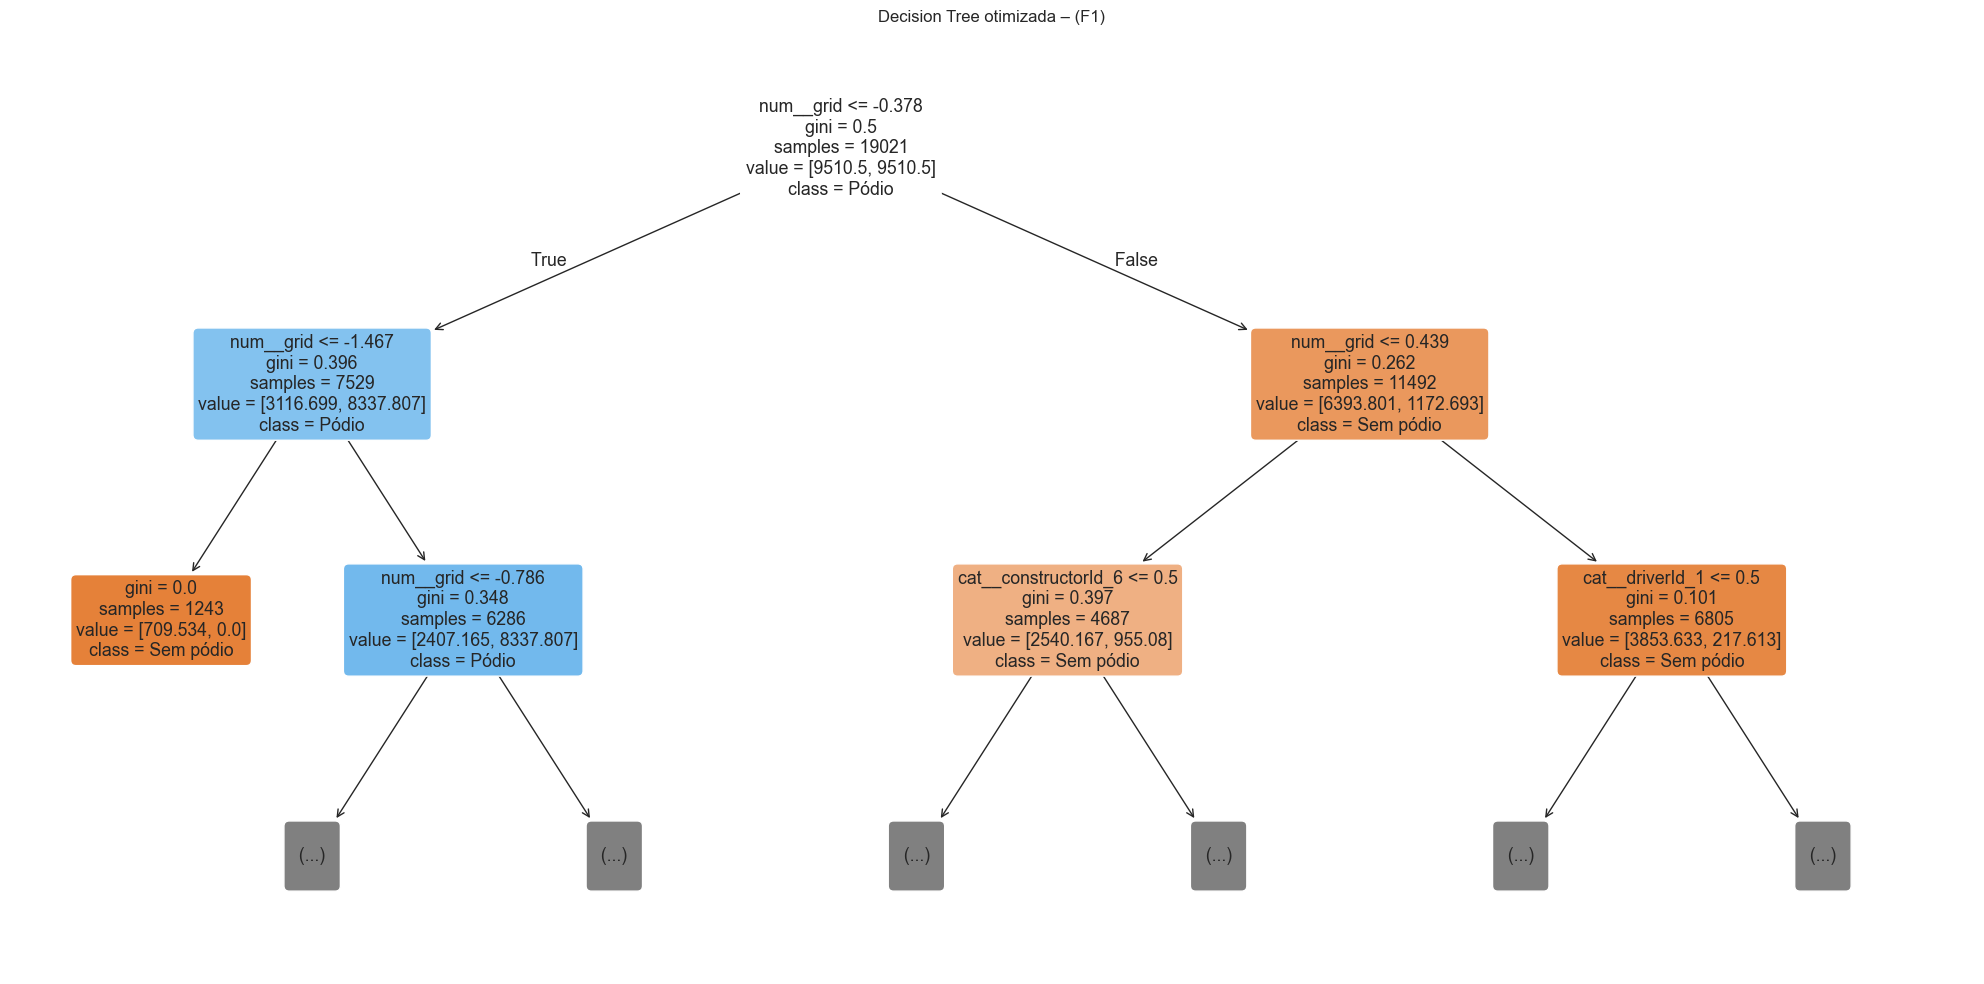

In [23]:
from sklearn.tree import plot_tree

# Obter o modelo DecisionTreeClassifier dentro do Pipeline
tree_clf = best_tree.named_steps["model"]

# Obter os nomes das features depois do preprocessor (num + one-hot)
feature_names = best_tree.named_steps["preprocess"].get_feature_names_out()

# Plot da árvore de decisão otimizada 
plt.figure(figsize=(20, 10))
plot_tree(
    tree_clf,
    feature_names=feature_names,
    class_names=["Sem pódio", "Pódio"],
    filled=True,
    rounded=True,
    max_depth=2     
)
plt.title("Decision Tree otimizada – (F1)")
plt.tight_layout()
plt.show()


#### Gráfico da matriz de confusão da Decision Tree otimizada

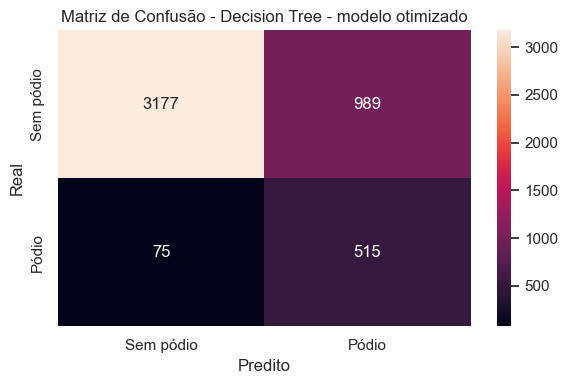

In [24]:
# Gráfico da matriz de confusão da Decision Tree otimizada
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_tree_opt,
    annot=True,
    fmt="d",
    xticklabels=["Sem pódio", "Pódio"],
    yticklabels=["Sem pódio", "Pódio"]
)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Decision Tree - modelo otimizado")
plt.tight_layout()
plt.show()


## 7. Conclusão

### 7.1. Resultados dos modelos base (SVM vs Decision Tree)

Depois de preparado o dataset (junção dos ficheiros, criação da variável `Podium`, seleção de features, divisão treino/teste e pré-processamento), foram treinados dois modelos:

- **SVM (RBF)**  
- **Decision Tree**

Os resultados no conjunto de teste foram:

	Modelo	        Accuracy	 Balanced_Accuracy
	SVM (RBF)    	0.874685	 0.673138
	Decision Tree 	0.852817 	 0.670112


Observações:

- Ambos os modelos apresentam accuracy elevada 0.87 no SVM e 0.85 na decision tree, o que é expectável, dado que a maioria dos registos pertence à classe Sem pódio.
- A **Balanced Accuracy** é semelhante nos dois casos (aproximadamente 0.67), indicando que nenhum dos modelos base consegue ainda equilibrar muito bem o desempenho entre sem pódio e podio.

---

### 7.2. Resultados da Decision Tree Otimizada

A Decision Tree foi otimizada com `GridSearchCV`, tendo como objetivo maximizar a **Balanced Accuracy**.

No conjunto de teste, o modelo otimizado obteve:

- **Accuracy (test)**: **0.7763**  
- **Balanced Accuracy (test)**: **0.8177**

Ou Seja:

- A **accuracy** desce de 0.85 para 0.78, porque o modelo passa aarriscar mais na classe minoritária.  
- A **Balanced Accuracy** sobe bastante de 0.67 para 0.82, o que indica um desempenho muito melhor e mais equilibrado entre as duas classes, especialmente na deteção de pódios.

Analisando o *classification report*:

- **Classe 1 (Pódio)**  
  - **recall = 0.87**: o modelo consegue identificar a grande maioria dos pódios (baixa taxa de falsos negativos).  
  - **precision = 0.34**: muitos dos pódios previstos acabam por não ser pódio (há mais falsos positivos), o que explica a descida da accuracy global.  

- **Classe 0 (Sem pódio)**  
  - **precision = 0.98**: quando o modelo prevê “Sem pódio”, geralmente acerta.  
  - **recall = 0.76**: ainda falha alguns casos, classificando-os como pódio.

A matriz de confusão da Decision Tree otimizada foi:

- **[[3177, 989], [75, 515]]**, onde:
  - 3177 - **verdadeiros negativos** (Sem pódio previstos como Sem pódio)  
  - 989  - **falsos positivos** (Sem pódio previstos como Pódio)  
  - 75   - **falsos negativos** (Pódio previstos como Sem pódio)  
  - 515  - **verdadeiros positivos** (Pódio previstos como Pódio)

Comparando com a árvore base **[[3804, 362], [338, 252]]**, verifica-se que:

- Os **verdadeiros positivos** (pódios corretamente previstos) sobem de **252** para **515**;  
- Os **falsos negativos** (pódios falhados) descem de **338** para **75**;  
- Em contrapartida, aumentam os **falsos positivos** de **362** para **989**, o que reduz a accuracy.

Em resumo, a otimização tornou o modelo muito mais competente a detetar pódios.



---

### 7.3. Comparação global e conclusões

Resumindo:

- Os modelos base (SVM e Decision Tree) apresentaram boa accuracy, mas Balanced Accuracy relativamente moderada (0.67), com tendência para favorecer a classe maioritária.
- A **Decision Tree otimizada** conseguiu melhorar significativamente a **Balanced Accuracy** (0.82), mostrando muito melhor capacidade para detetar pódios.
